# Lec 04. Logistic Regression #

## Assignment 04. Softmax Classification in MNIST ##

### Review ###  

**모델(Model)** : Logistic Function(Sigmoid Function) and Softmax Function
$$y=\frac{1}{1+e^-(Wx+b)}$$  
우리가 Logistic Regression, 즉 Binary Classification 문제에서 사용하는 Model, 또는 가설(Hypothesis)는 위와 같았습니다.  
방금 수업때에도 언급되었듯이, Linear Regression에서는 값 그 자체를 추정하는 문제였다면,  
Logistic Regression에서는 값 그 자체를 추정하는 것이 아닌, **그 값이 나올 확률**을 추정하는 문제가 됩니다.  
위 모델의 Function을 **Sigmoid Function**이라 부르고, Bayes Rule을 통해 식을 정리하였을 때 값이 나올 확률(posterior)이 Sigmoid Function으로 정리되었습니다.  

$$y_i=\frac{e^{W_i+b_i}}{\sum_je^{W_j+b_j}}$$  
Logistic Regression이 Binary Classification에서 사용하는 Model이었다면, 여러개의 클래스로 분류하는 Multi-Class Classification에서는 위와 같은 식을 사용합니다.  
이 식 역시 확률값을 Bayes Rule을 통해서 정리하면서 도출된 식이었습니다.  
위 Function을 **Softmax Function**이라 부르고, 각 클래스의 확률들의 합을 1로 만들어주는 Normalization의 역할을 한다고 볼 수 있습니다.  

**모수(Parameter)** : W, b  
모델은 결정하였으니, 주어진 데이터에 가장 잘 맞는 모델의 파라메터를 결정할 필요가 있습니다.  
Logistic Regression에서는 Linear Regression과 마찬가지로 Sigmoid Function의 지수항에 올려져있는 W와 b를 추정하게 됩니다.  
Gradient Descent와 같은 학습 알고리즘을 통해서 가장 최적의(Optimal) Parameter를 찾을 수 있습니다.

**오차 함수(Error Function)** : Cross Entropy  
$$L = -\sum_i \hat{y}_ilog(y_i)$$  
수업을 잠시 되짚어보면 MSE를 Classification 문제에 활용하였을때는 하나의 Optimal Point를 가지지 않기 때문에 모델이 최적의 해를 찾을 수 없다는 단점이 있었습니다. 따라서 새로운 Loss Function을 찾아볼 필요가 있었고, Maximum Likelihood Estimation의 식으로부터 Cross Entropy를 유도해낼 수 있었습니다.

### MNIST Dataset ###
눈에 잘 안보이는 Iris Dataset은 했으니, 이제 새로운 데이터셋에 대해서 학습을 해볼게요!  
MNIST라고 불리는 데이터셋은 손글씨들을 모아놓은 데이터셋입니다.  
그중에서도, 0부터 9까지 Digits를 직접 손으로 쓴 데이터셋을 가지고 있습니다.  

MNIST는 인공지능, 그중에서도 컴퓨터 비젼 연구의 권위자인 LeCun 교수님이 만든 데이터셋이며,  
딥러닝계의 Hello World!와도 같은 데이터셋입니다.  

MNIST는 [28x28]의 고정 크기 이미지로 되어있으며, 각 글자가 중심에 배치되어 있습니다.  
총 6만개의 Training Set과 1만개의 Test Set으로 나누어져 있습니다.  

MNIST Dataset은 매우 많이 쓰이는 Dataset이라서, PyTorch의 `torchvision` 라이브러리에서 쉽게 `Dataset` 형태로 제공합니다.  
그러면, 직접 한번 어떻게 생겼는지 볼게요!

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
# Issue : https://github.com/pytorch/vision/issues/1938
# 이 아래 내용을 꼭 써주셔야합니다.
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# MNIST는 아래와 같이 Dataset을 불러올 수 있습니다.
train_data = dsets.MNIST(root='data/', train=True, transform=T.ToTensor(), download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=T.ToTensor(), download=True)
print('training data: ', len(train_data))
print('test data: ', len(test_data))

training data:  60000
test data:  10000


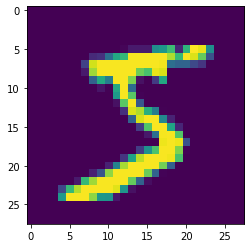

In [3]:
image = train_data[0][0].detach().numpy().squeeze()
plt.imshow(image)

손글씨가 잘 보이시나요?  
이러한 이미지 데이터셋은 2차원 Array의 형태로 구성되어 있습니다.  
앞서 설명하였듯이, 28x28의 2차원 Array로 구성되어 있죠!  
하지만, 이제 이 데이터를 Logistic Regression하기 전에, 우리는 아직 1차원 데이터에 대해서만 학습하는것을 배웠습니다!  
그래서 한줄로 펴줄 필요가 있겠죠.  
2차원 Array는 PyTorch에서 아래와 같이 펴줄 수 있습니다.
```python
torch_tensor.view(-1, 28*28)
```

In [4]:
image_tensor = torch.Tensor(image)
print("Before Flatten:", image_tensor.shape)

flatten_tensor = image_tensor.view(-1, 28*28)
print("After Flatten:", flatten_tensor.shape)

Before Flatten: torch.Size([28, 28])
After Flatten: torch.Size([1, 784])


## 과제 명세
MNIST Dataset을 회합때 배웠던 Softmax Regression을 통해 분류해보아요!    
모델 `MNISTModel`과 함수 `train(model)`의 내용을 수업때의 자료를 참고하여 만들어주시면 됩니다.
- train(model)은 MNISTModel객체를 인자로 받습니다.  
- 모델이나 학습코드는 자유롭게 변형하셔도 좋습니다.

## 여기 아래부터 코드를 작성해주세요!

In [5]:
############### 이 부분을 작성하여 메일로 보내주세요. ###############

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        ###### 필요한 내용을 채워주세요!! ######
        
        
        
        
        ###### 필요한 내용을 채워주세요!! ######
        
    def forward(self, x):
        ###### 필요한 내용을 채워주세요!! ######
        
        
        
        
        ###### 필요한 내용을 채워주세요!! ######
        return x
    

def train(model):
    train_data = dsets.MNIST(root='data/',
                             download=True,
                             train=True,
                             transform=T.ToTensor())
    test_data = dsets.MNIST(root='data/',
                            download=True,
                            train=False,
                            transform=T.ToTensor())
    
    train_loader = data.DataLoader(train_data, shuffle=True, batch_size=32)
    test_loader = data.DataLoader(test_data, shuffle=False)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    losses = []
    
    n_epoch = 20
    for epoch in range(n_epoch):
        epoch_loss = 0
        ###### 필요한 내용을 채워주세요!! ######
        
        
        
        
        ###### 필요한 내용을 채워주세요!! ######
        print('EPOCH[{current}|{total}] loss: {loss:.2f}'.format(
            current=epoch+1,
            total=n_epoch,
            loss=epoch_loss
        ))
    
############### 이 부분을 작성하여 메일로 보내주세요. ###############

## Testing
아래 코드로 정확도를 테스트해볼 수 있습니다.

In [6]:
# Your Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MNISTModel()
model = model.to(device)

# Test the model using test sets
test_data = dsets.MNIST(root='data/',
                        download=True,
                        train=False,
                        transform=T.ToTensor())


with torch.no_grad():
    X_test = test_data.data.view(-1, 28 * 28).float().to(device)
    Y_test = test_data.targets.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.0
